<a href="https://colab.research.google.com/github/mmimet/GBC-capstone-Alzheimer-Brain-Tumor/blob/main/Capstone_Project_Cloudport_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><h1><center>Alzheimer's Classification and Brain Tumor Relationship Analysis using Annotated MRI Datasets</center></h1></b>

### Mounting of Google Drive to access dataset:

In [ ]:
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Alzheimer dataset:**

# **1. Data Preprocessing:**

###Loading important libraries:

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

###Loading dataset folders classified into different categories:


In [ ]:
# Specify the directory containing the dataset
data_path = '/content/drive/MyDrive/Capstone Project/Alzheimer'

# Define parameters
batch_size = 24
image_size = (256, 256)
shuffle = True
seed = 40

# Load the data
data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_path,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=shuffle,
    seed=seed
)

# Retrieve the names of the classes
class_names = data.class_names

# Display the names of the classes
print("Identified classes:", class_names)

Found 6400 files belonging to 4 classes.
Identified classes: ['Mild_Demented', 'Moderated__Demented', 'Non_Demented', 'Very_Mild_Demented']


###Distribution of each class:

In [ ]:
class_counts = {}

class_counts = {}
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

for key, value in class_counts.items():
    print(f'Number of images for {key}: {value}')

Number of images for Mild_Demented: 896
Number of images for Non_Demented: 3200
Number of images for Very_Mild_Demented: 2240
Number of images for Moderated__Demented: 64


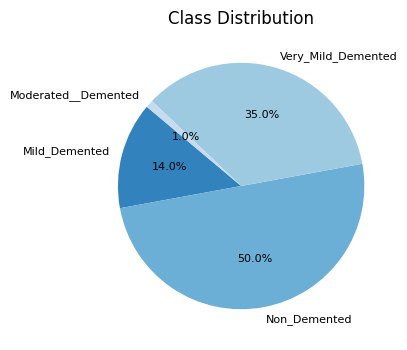

In [ ]:
# Pie plot for visualizing class distribution

# Colors for each slice
colors = plt.cm.tab20c.colors
num_classes = len(class_counts)
color_selection = colors[:num_classes]

# Custom autopct function to control label size
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''


plt.figure(figsize=(4, 4))
plt.pie(class_counts.values(), labels=class_counts.keys(), colors=color_selection,
        autopct=custom_autopct, startangle=140, textprops={'fontsize': 8})
plt.title('Class Distribution')
plt.show()

###MRI Samples For Each Class:

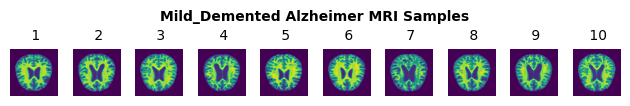

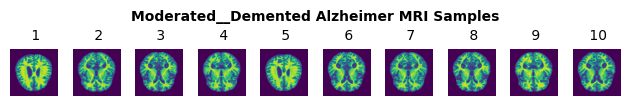

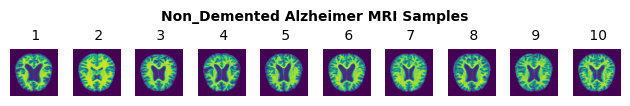

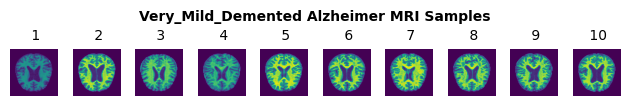

In [ ]:
def sample_images(directory, category, samples_count=10):
    category_directory = os.path.join(directory, category)
    jpg_images = [file for file in os.listdir(category_directory) if file.lower().endswith('.jpg')]

    figure, axes = plt.subplots(1, samples_count, facecolor="white")
    figure.suptitle(f'{category} Alzheimer MRI Samples', color="black", fontsize=10, fontweight='bold', y=0.6)

    for index in range(samples_count):
        file_path = os.path.join(category_directory, jpg_images[index])
        image = mpimg.imread(file_path)

        axes[index].imshow(image)
        axes[index].set_axis_off()
        axes[index].set_title(f' {index+1}', color="black", fontsize=10)

    plt.tight_layout()

for category_name in class_names:
    sample_images(data_path, category=category_name)

###Normalization:

In [ ]:
def normalize_images(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

# Apply normalization
normalized_data_alz = data.map(normalize_images)

In [ ]:
# Check normalization
for images, _ in normalized_data_alz.take(1):  # Take 1 batch
    print("Images are normalized." if images.numpy().min() >= 0 and images.numpy().max() <= 1 else "Images are not normalized.")
    print("Min pixel value:", images.numpy().min())
    print("Max pixel value:", images.numpy().max())

Images are normalized.
Min pixel value: 0.0
Max pixel value: 0.9892157


In [ ]:
import pandas as pd
import os
import tensorflow as tf

# Path to your dataset
data_path = '/content/drive/MyDrive/Capstone Project/Alzheimer'

# class_names is defined
class_names = ['Mild_Demented', 'Moderated__Demented', 'Non_Demented', 'Very_Mild_Demented']

# Function to create a DataFrame with all image paths and their labels
def create_image_dataframe(directory_path, class_names):
    data = []
    for class_name in class_names:
        class_path = os.path.join(directory_path, class_name)
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                data.append({
                    'ImagePath': os.path.join(class_path, img_name),  # Source
                    'Label': class_name,  # Target
                })
    return pd.DataFrame(data)

# Create the DataFrame with paths and labels
df = create_image_dataframe(data_path, class_names)

# Randomly sample 100 images
sample_df = df.sample(n=100, random_state=42).reset_index(drop=True)

# Save the sampled DataFrame to a CSV file
sample_file_path = '/content/drive/MyDrive/Capstone Project/sample_analytical_file.csv'
sample_df.to_csv(sample_file_path, index=False)

print(f"Sample of 100 images saved to {sample_file_path}.")

Sample of 100 images saved to /content/drive/MyDrive/Capstone Project/sample_analytical_file.csv.


# **2. Model Development:**

### Splitting data: **(70% Training, 20% Validation, 10% Testing)**



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Define the sizes for training, validation, and testing sets
train_size = 0.7
validation_size = 0.2
test_size = 0.1  # Ensure these add up to 1.0

# Assuming normalized_data is your Dataset object
X = []
y = []

# Extract data from the dataset iterator
for images, labels in normalized_data_alz.unbatch().as_numpy_iterator():
    X.append(images)
    y.append(labels)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Convert class names in y to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # This encodes class names to integers

# Split data into training and remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y_encoded, train_size=train_size, random_state=seed)

# Further split remaining data into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=test_size/(test_size + validation_size), random_state=seed)

# Print the sizes of each set
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

Training set size: 4480
Validation set size: 1280
Testing set size: 640


### Building the CNN Model:

In [ ]:
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

input_shape = (256, 256, 3)
num_classes = len(class_names)


def build_optimized_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)


model = build_optimized_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

### Class Weights:

In [ ]:
# Initialize an empty list to collect labels
train_labels_list = []

# Iterate over the labels in y_train
for labels in y_train:
    train_labels_list.append(labels)

# Convert it to a numpy array for further processing
train_labels = np.array(train_labels_list)

# Now you can calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Calculated class weights: ", class_weights_dict)

Calculated class weights:  {0: 1.7391304347826086, 1: 25.454545454545453, 2: 0.4951370468611848, 3: 0.7320261437908496}


### Model training:

In [ ]:
history_alz = model.fit(
    X_train, train_labels, epochs=40,  # Increase epochs since we have early stopping
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopper, lr_scheduler]
)

Epoch 1/40
140/140 [==============================] - 12s 48ms/step - loss: 2.2848 - accuracy: 0.3672 - val_loss: 1.3577 - val_accuracy: 0.4898 - lr: 0.0010
Epoch 2/40
140/140 [==============================] - 4s 30ms/step - loss: 1.3823 - accuracy: 0.3493 - val_loss: 1.3329 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 3/40
140/140 [==============================] - 4s 30ms/step - loss: 1.3548 - accuracy: 0.3955 - val_loss: 1.2214 - val_accuracy: 0.4469 - lr: 0.0010
Epoch 4/40
140/140 [==============================] - 4s 30ms/step - loss: 1.3308 - accuracy: 0.3060 - val_loss: 1.3554 - val_accuracy: 0.3172 - lr: 0.0010
Epoch 5/40
140/140 [==============================] - 5s 33ms/step - loss: 1.2727 - accuracy: 0.4187 - val_loss: 1.1756 - val_accuracy: 0.4578 - lr: 0.0010
Epoch 6/40
140/140 [==============================] - 4s 31ms/step - loss: 1.0485 - accuracy: 0.4596 - val_loss: 1.0414 - val_accuracy: 0.4891 - lr: 0.0010
Epoch 7/40
140/140 [==============================] - 4s 31ms/s

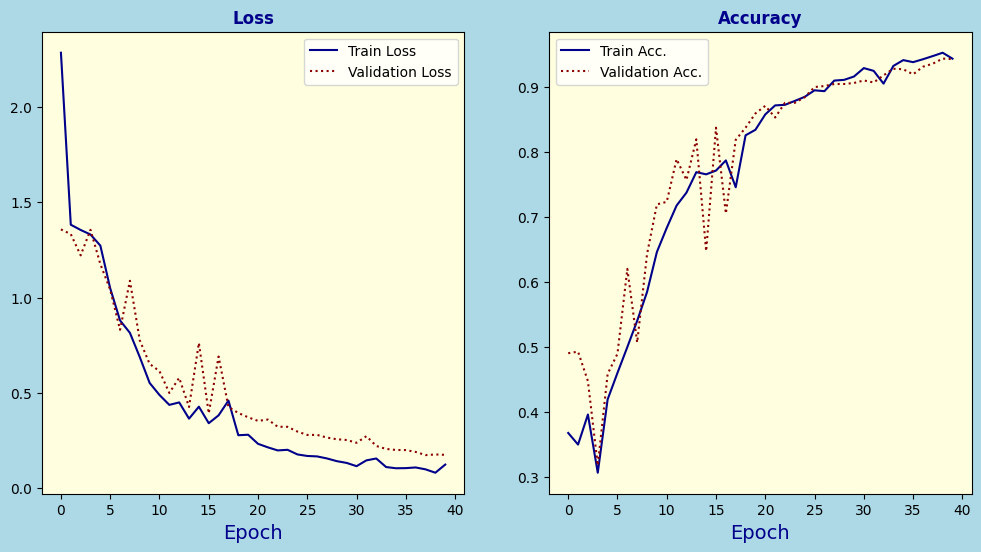

In [ ]:
import matplotlib.pyplot as plt

# Function to plot the training and validation loss and accuracy
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="lightblue")

# Plot for the training and validation loss
    ax[0].set_facecolor('lightyellow')
    ax[0].set_title('Loss', fontweight="bold", color="darkblue")
    ax[0].set_xlabel("Epoch", size=14, color="darkblue")
    ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="darkblue")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="darkred", linestyle="dotted")
    ax[0].legend()

    # Plot for the training and validation accuracy
    ax[1].set_facecolor('lightyellow')
    ax[1].set_title('Accuracy', fontweight="bold", color="darkblue")
    ax[1].set_xlabel("Epoch", size=14, color="darkblue")
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="darkblue")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="darkred", linestyle="dotted")
    ax[1].legend()

    plt.show()

# Assuming 'history_alz' is your training history object for the brain tumor model
plot_training_history(history_alz)

## Confusion Matrix

20/20 [==============================] - 0s 13ms/step


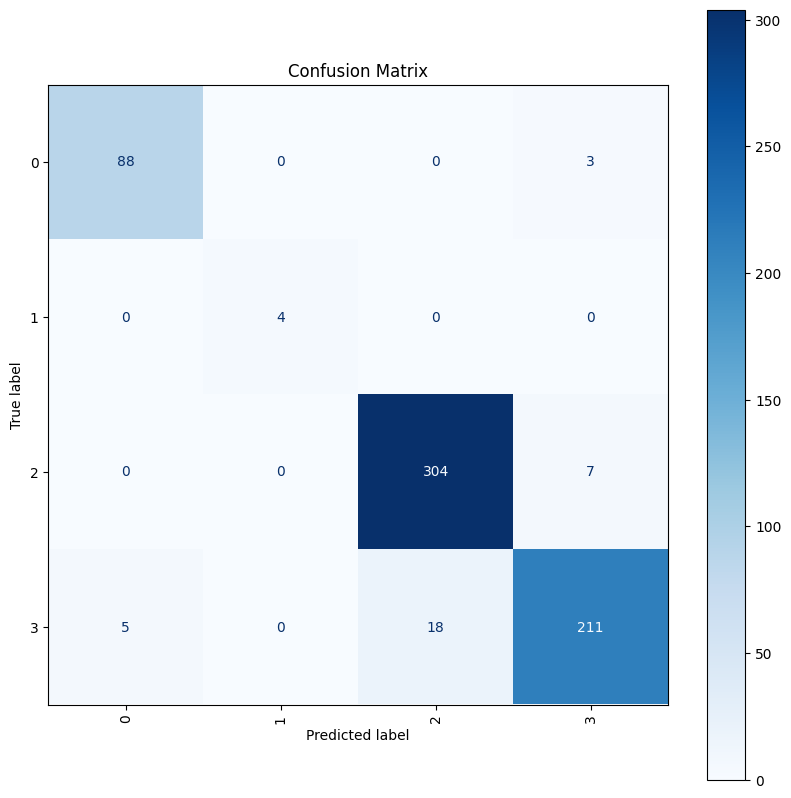

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict the classes using the trained model on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Convert class indices to string names, if necessary
class_names = [str(name) for name in label_encoder.classes_]

# Generate the classification report using the string names
report = classification_report(y_test, y_pred_classes, target_names=class_names)

# Print the classification report
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        91
           1       1.00      1.00      1.00         4
           2       0.94      0.98      0.96       311
           3       0.95      0.90      0.93       234

    accuracy                           0.95       640
   macro avg       0.96      0.96      0.96       640
weighted avg       0.95      0.95      0.95       640



#**Brain Tumor dataset:**

# **1. Preprocessing Data:**

### Loading dataset folders:

In [ ]:
def load_and_preprocess_data(directory, batch_size, image_size):
    # Load the dataset with resizing and shuffling
    data_BT = tf.keras.preprocessing.image_dataset_from_directory(
        directory=directory,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=40,
        label_mode='binary'  # for binary classification problem
    )

    # Define normalization (rescaling the images to [0,1])
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

    # Apply the normalization layer to the dataset
    normalized_data_BT = data_BT.map(lambda x, y: (normalization_layer(x), y))

    return normalized_data_BT

# Parameters for data loading
dataBT_path = '/content/drive/MyDrive/Capstone Project/Brain_Tumor'
batch_size = 24
image_size = (256, 256)

# Load and preprocess the data
normalized_data_bt = load_and_preprocess_data(dataBT_path, batch_size, image_size)

Found 253 files belonging to 2 classes.


### Check Normalization:

In [ ]:
# Check normalization
for images, _ in normalized_data_bt.take(1):  # Take 1 batch
    print("Images are normalized." if images.numpy().min() >= 0 and images.numpy().max() <= 1 else "Images are not normalized.")
    print("Min pixel value:", images.numpy().min())
    print("Max pixel value:", images.numpy().max())

Images are normalized.
Min pixel value: 0.0
Max pixel value: 1.0


###Distribution of each class:

In [ ]:
classBT_counts = {}
for classBT_name in os.listdir(dataBT_path):
    classBT_path = os.path.join(dataBT_path, classBT_name)
    if os.path.isdir(classBT_path):
        classBT_counts[classBT_name] = len(os.listdir(classBT_path))

# Display the number of images for each class
for key, value in classBT_counts.items():
    print(f'Number of images for {key}: {value}')

Number of images for no: 98
Number of images for yes: 155


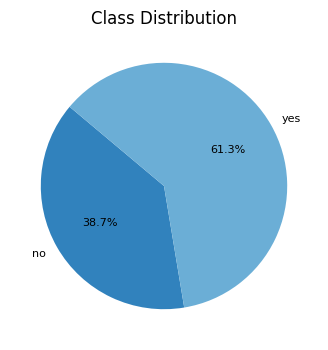

In [ ]:
# Pie plot for visualizing class distribution
colors = plt.cm.tab20c.colors
num_classes = len(classBT_counts)
color_selection = colors[:num_classes]

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

plt.figure(figsize=(4, 4))
plt.pie(classBT_counts.values(), labels=classBT_counts.keys(), colors=color_selection,
        autopct=custom_autopct, startangle=140, textprops={'fontsize': 8})
plt.title('Class Distribution')
plt.show()

###MRI Samples For Each Class: (after resizing and normalization)

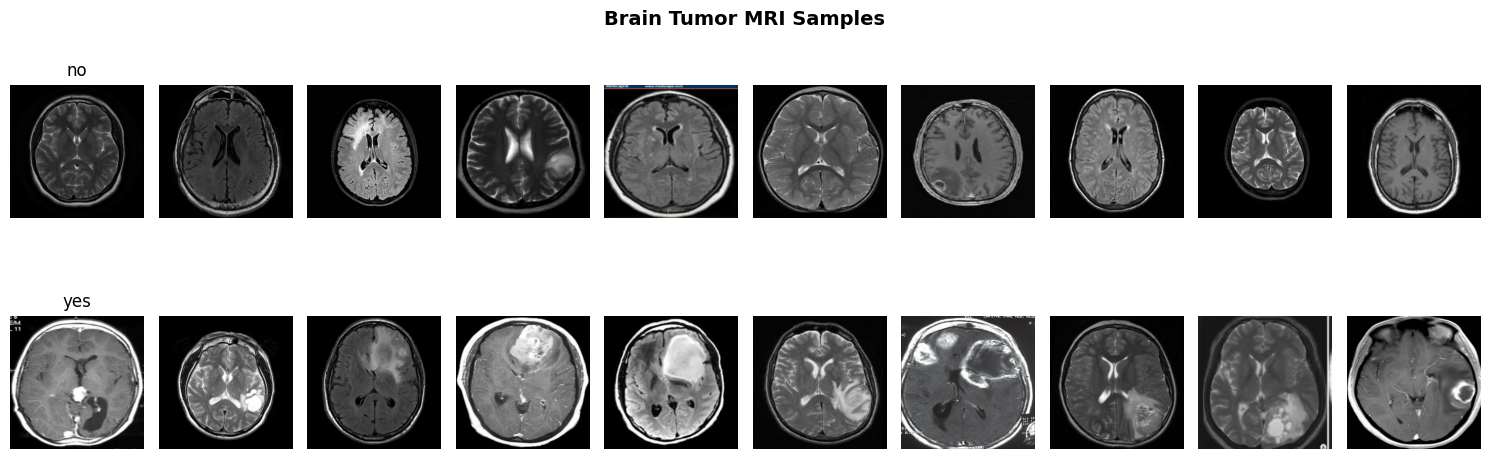

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_class_samples(dataset, classBT_name, samples_per_class=10):
    # Initialize a dictionary to store the samples
    samples = {name: [] for name in classBT_name}

    # Iterate over the dataset to collect samples
    for images, labels in dataset.unbatch().as_numpy_iterator():
        class_index = int(labels)  # labels are already numpy arrays, direct conversion to int
        class_name = classBT_name[class_index]
        if len(samples[class_name]) < samples_per_class:
            samples[class_name].append(images)

        # Check if all classes have enough samples; if so, break early
        if all(len(v) == samples_per_class for v in samples.values()):
            break

    # Create a grid of subplots
    num_classes = len(classBT_name)
    fig, axes = plt.subplots(nrows=num_classes, ncols=samples_per_class, figsize=(15, 3 * num_classes))
    fig.suptitle('Brain Tumor MRI Samples', fontsize=14, fontweight='bold', y=0.9)

    for i, class_name in enumerate(classBT_name):
        for j in range(samples_per_class):
            ax = axes[i][j] if num_classes > 1 else axes[j]
            if j < len(samples[class_name]):
                ax.imshow(samples[class_name][j], cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name)

    plt.tight_layout()
    plt.show()

# Example usage
classBT_name = ['no', 'yes']  # Use your actual class names
display_class_samples(normalized_data_bt, classBT_name)

# **2. Model Development:**

### Splitting data: **(70% Training, 20% Validation, 10% Testing)**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define the sizes for training, validation, and testing sets
train_size = 0.7
validation_size = 0.2
test_size = 0.1  # Ensure these add up to 1.0

# Assuming normalized_data_bt is your Dataset object for the Brain Tumor dataset
X_bt = []
y_bt = []

# Extract data from the dataset iterator
for images, labels in normalized_data_bt.unbatch().as_numpy_iterator():
    X_bt.append(images)
    y_bt.append(labels)

# Convert lists to numpy arrays
X_bt = np.array(X_bt)
y_bt = np.array(y_bt)

# Convert class names in y to integers
label_encoder_bt = LabelEncoder()
y_encoded_bt = label_encoder_bt.fit_transform(y_bt)  # This encodes class names to integers

# Split data into training and remaining data
X_train_bt, X_remaining_bt, y_train_bt, y_remaining_bt = train_test_split(
    X_bt, y_encoded_bt, train_size=train_size, random_state=seed)

# Further split remaining data into validation and testing sets
X_val_bt, X_test_bt, y_val_bt, y_test_bt = train_test_split(
    X_remaining_bt, y_remaining_bt, test_size=test_size/(test_size + validation_size), random_state=seed)

# Print the sizes of each set
print("Training set size:", len(X_train_bt))
print("Validation set size:", len(X_val_bt))
print("Testing set size:", len(X_test_bt))

Training set size: 177
Validation set size: 50
Testing set size: 26


### Model training:

In [ ]:
# Fit the model to the brain tumor dataset
history_bt = model.fit(
    X_train_bt,  # Training features for brain tumor
    y_train_bt,  # Training labels for brain tumor
    epochs=10,
    validation_data=(X_val_bt, y_val_bt)  # Validation data for brain tumor
)

Epoch 1/10
6/6 [==============================] - 1s 203ms/step - loss: 33.5031 - accuracy: 0.1243 - val_loss: 18.7390 - val_accuracy: 0.2000
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 12.4901 - accuracy: 0.3277 - val_loss: 5.2599 - val_accuracy: 0.5800
Epoch 3/10
6/6 [==============================] - 0s 36ms/step - loss: 4.8044 - accuracy: 0.5819 - val_loss: 2.6448 - val_accuracy: 0.8000
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss: 2.6928 - accuracy: 0.6667 - val_loss: 1.9580 - val_accuracy: 0.7800
Epoch 5/10
6/6 [==============================] - 0s 38ms/step - loss: 2.1398 - accuracy: 0.6893 - val_loss: 1.7004 - val_accuracy: 0.8000
Epoch 6/10
6/6 [==============================] - 0s 37ms/step - loss: 1.6409 - accuracy: 0.7175 - val_loss: 1.4838 - val_accuracy: 0.8000
Epoch 7/10
6/6 [==============================] - 0s 39ms/step - loss: 1.5698 - accuracy: 0.7401 - val_loss: 1.2996 - val_accuracy: 0.8000
Epoch 8/10
6/6 [=======

### Loss vs Accuracy:

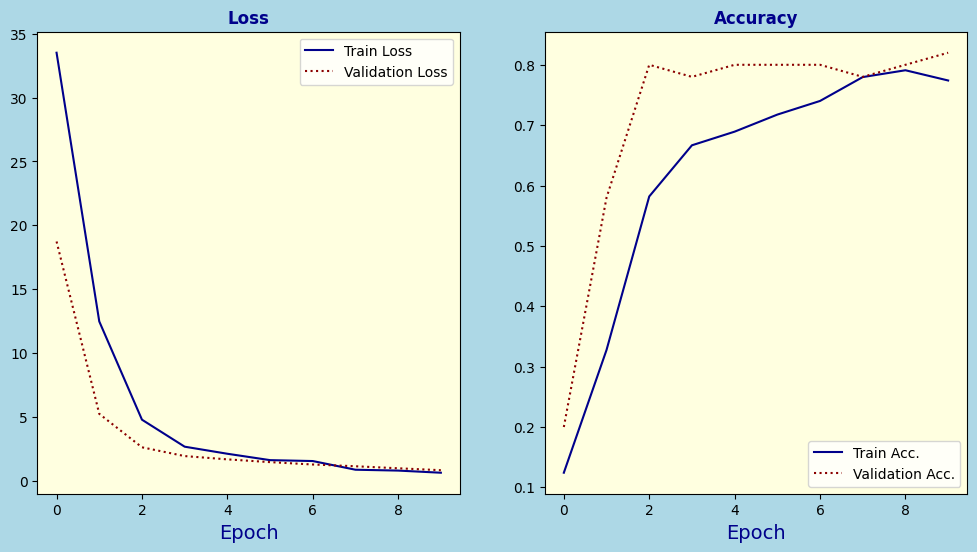

In [ ]:
# Assuming 'history_bt' is your training history object for the brain tumor model
plot_training_history(history_bt)

### Confusion Matrix:

1/1 [==============================] - 0s 284ms/step


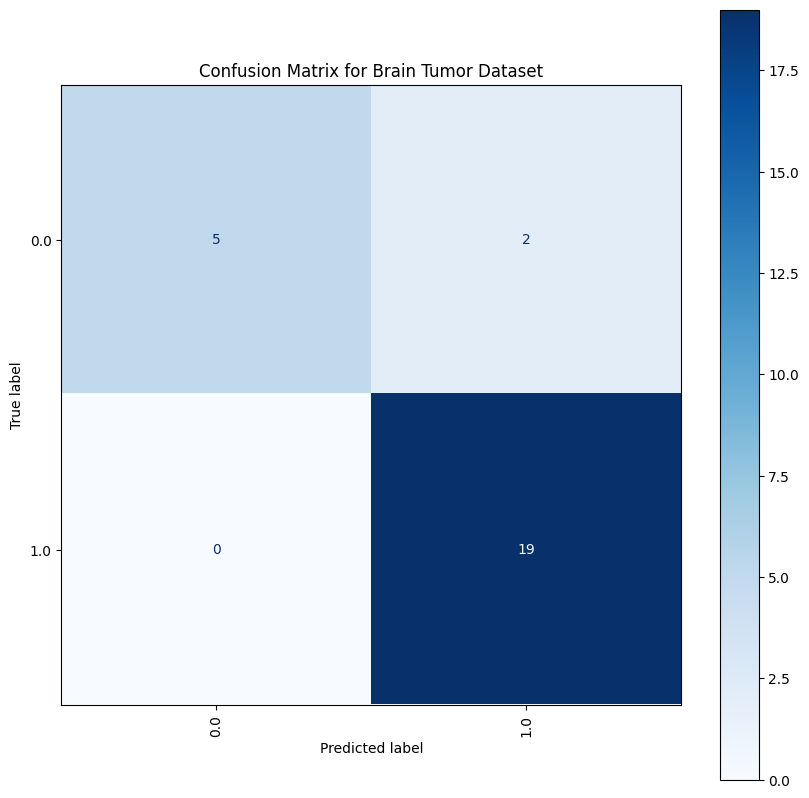

In [ ]:
# Predict the classes using the trained model on the test data for brain tumor
y_pred_bt = model.predict(X_test_bt)
y_pred_classes_bt = np.argmax(y_pred_bt, axis=1)  # Convert probabilities to class labels

# Compute the confusion matrix for the brain tumor dataset
conf_matrix_bt = confusion_matrix(y_test_bt, y_pred_classes_bt)

# Plotting the confusion matrix for the brain tumor dataset
fig, ax = plt.subplots(figsize=(10, 10))
disp_bt = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bt, display_labels=label_encoder_bt.classes_)
disp_bt.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Brain Tumor Dataset')
plt.xticks(rotation=90)
plt.show()

### Classification Report:

In [ ]:
from sklearn.metrics import classification_report

# Assuming 'label_encoder_bt' is your LabelEncoder instance for brain tumor data.
# Convert class indices to string names, if necessary
class_names_bt = [str(name) for name in label_encoder_bt.classes_]

# Generate the classification report using the string names for brain tumor data
report_bt = classification_report(y_test_bt, y_pred_classes_bt, target_names=class_names_bt)

# Print the classification report for the brain tumor dataset
print("Classification Report for Brain Tumor Dataset:\n", report_bt)


Classification Report for Brain Tumor Dataset:
               precision    recall  f1-score   support

         0.0       1.00      0.71      0.83         7
         1.0       0.90      1.00      0.95        19

    accuracy                           0.92        26
   macro avg       0.95      0.86      0.89        26
weighted avg       0.93      0.92      0.92        26



 # **3. Brain Tumor Relationship Analysis:**

## Extract Features Using Trained Model:

### Define the Feature Extractor:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Assume 'model' is your trained model for both Alzheimer's and brain tumors
# Modify the model to act as a feature extractor
feature_extractor = Model(inputs=model.input, outputs=model.layers[-5].output)

### Preprocess and Extract Features:

In [ ]:
# Define the feature extraction function with batch processing
def preprocess_and_extract_features(dataset, feature_extractor_model, batch_size=32):
    feature_list = []
    label_list = []
    for images, labels in dataset.unbatch().batch(batch_size):
        features = feature_extractor_model.predict(images)  # Process in batches
        features_flat = features.reshape(features.shape[0], -1)  # Flatten the features
        feature_list.append(features_flat)
        label_list.append(labels.numpy())  # Ensure labels are NumPy arrays
    # Concatenate all batches
    features_all = np.vstack(feature_list)
    labels_all = np.concatenate(label_list)
    return features_all, labels_all

### Perform PCA and Clustering:

In [ ]:
# Assuming 'normalized_data_alz' and 'normalized_data_bt' are your preprocessed Dataset objects
features_alz_flat, y_alz = preprocess_and_extract_features(normalized_data_alz, feature_extractor, batch_size=32)
features_bt_flat, y_bt = preprocess_and_extract_features(normalized_data_bt, feature_extractor, batch_size=32)

# Make sure y_alz and y_bt are 1D arrays before concatenating
y_alz = y_alz.ravel()  # Flatten if not already 1D
y_bt = y_bt.ravel()    # Flatten if not already 1D

# Adjust y_bt labels to ensure they do not overlap with y_alz labels
y_bt_adjusted = y_bt + np.max(y_alz) + 1  # This makes sure that brain tumor labels are distinct from Alzheimer's labels

# Concatenate all features and labels
all_features_flat = np.vstack((features_alz_flat, features_bt_flat))

# Scale the features
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features_flat)

# Perform PCA on the scaled features
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(all_features_scaled)

1/1 [==============================] - 0s 293ms/step


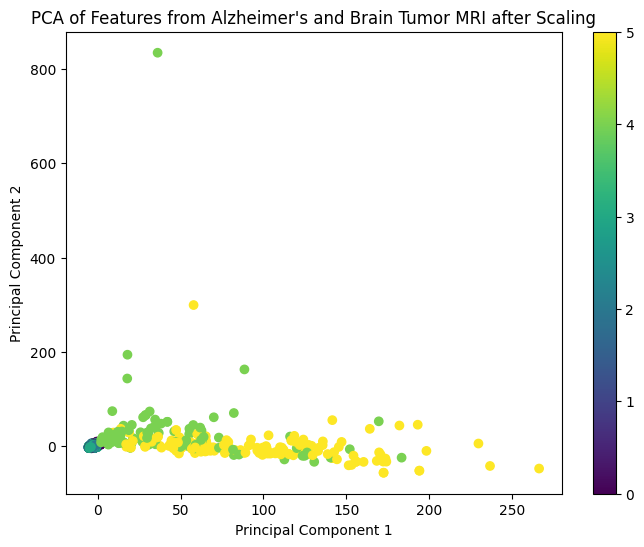

In [ ]:
# Since we have 4 classes for Alzheimer's and 2 for brain tumor, we need 6 clusters
kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(reduced_features)

# Plot the results using the true labels
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
true_labels = np.concatenate([y_alz, y_bt_adjusted])
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=true_labels, cmap='viridis', marker='o')
plt.title('PCA of Features from Alzheimer\'s and Brain Tumor MRI after Scaling')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

## Statistical Analysis:

### Silhouette Score:

In [ ]:
# Calculate silhouette score
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(all_features_scaled, clusters)
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.69


### Logistic Regression:

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Assuming that features_alz_flat and features_bt_flat are the extracted features for each dataset
# and that y_alz and y_bt are the corresponding labels

# Combine the features into a single dataset
X_combined = np.vstack((features_alz_flat, features_bt_flat))

# Combine the labels into a single array, ensuring brain tumor labels are distinct from Alzheimer's labels
# For example, if Alzheimer's labels are 0-3, you can add 4 to brain tumor labels to make them 4-5
y_combined = np.concatenate([y_alz, y_bt + 4])

# Split the combined dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Train a logistic regression model to predict the condition based on the features
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Evaluate the predictions
print(classification_report(y_test, y_pred))

# The coefficients of the logistic regression model indicate the association between features and conditions
print("Model coefficients:", logreg.coef_)

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91       179
         1.0       1.00      1.00      1.00        24
         2.0       0.94      0.94      0.94       659
         3.0       0.92      0.91      0.92       420
         4.0       0.85      0.61      0.71        18
         5.0       0.85      0.94      0.89        31

    accuracy                           0.93      1331
   macro avg       0.91      0.89      0.90      1331
weighted avg       0.93      0.93      0.93      1331

Model coefficients: [[-1.17265646e-04  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.42658418e-06  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.47752980e-04  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.17597331e-04  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.52416084e-04

### Correlation Matrix:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# This is a simple random sampling without replacement

random_indices = np.random.choice(all_features_scaled.shape[1], size=1000, replace=False)
reduced_features = all_features_scaled[:, random_indices]

# Calculate the correlation matrix for the reduced set of features
feature_correlation_matrix = np.corrcoef(reduced_features.T)  # Transpose to get features as rows

# Visualize the feature correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(feature_correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix for a Subset of Features')
plt.show()